### Importing necessary Libraries

In [31]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image as Image
import tensorflow as tf
import os
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.utils import to_categorical

### Loading the Dataset

In [40]:
dataset_path = '/content/Dataset'
sub_folders = os.listdir(dataset_path)
IMAGE_SHAPE = (224,224)
i=0
images=[]
labels=[]

path_lists=[]
temp=sub_folders

for sub_folder in sub_folders:
  sub_folder_index = temp.index(sub_folder)
  label = sub_folder_index

  if label==2:
    continue
  if label==3:
    label=2
  path = dataset_path+'/'+sub_folder
  sub_folder_images = os.listdir(path)

  #Reading images from the subfolder one at a time
  for image in sub_folder_images:
    image_path = path+'/'+image
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image,IMAGE_SHAPE)
    path_lists.append(image_path)
    images.append(resized_image)

    labels.append(label)
    i+=1


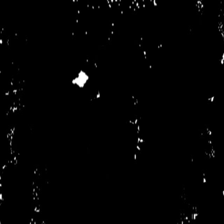

In [43]:
Image.open(str(path_lists[0])).resize(IMAGE_SHAPE)

### Data Preprocessing

In [44]:
images = np.array(images)
labels = np.array(labels)
defect_classes = ['Holes','Horizontal','Vertical']
num_of_classes = 3
classes_encoded = to_categorical(labels,num_classes = num_of_classes)

In [45]:
images = images/255.0

In [46]:
X_train,X_test,y_train,y_test = train_test_split(images,classes_encoded,test_size=0.2,random_state=10)

In [47]:
X_train.shape

(329, 224, 224, 3)

In [48]:
X_test.shape

(83, 224, 224, 3)

### Building and Training the CNN Model

In [49]:
defect_classifier = Sequential()

#Adding the CNN layers
defect_classifier.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(224,224,3)))
defect_classifier.add(MaxPooling2D(2,2))
defect_classifier.add(Conv2D(32,(3,3),1,activation='relu'))
defect_classifier.add(MaxPooling2D(2,2))
defect_classifier.add(Conv2D(64,(3,3),1,activation='relu'))
defect_classifier.add(MaxPooling2D(2,2))
defect_classifier.add(Conv2D(32,(3,3),1,activation='relu'))
defect_classifier.add(MaxPooling2D())
defect_classifier.add(Conv2D(16,(3,3),1,activation='relu'))
defect_classifier.add(MaxPooling2D())

#Flattening the output of Conv
defect_classifier.add(Flatten())

#Adding Hidden layers along with Dropout
defect_classifier.add(Dense(128,activation='relu'))
defect_classifier.add(Dropout(0.25))
defect_classifier.add(Dense(64,activation='relu'))
defect_classifier.add(Dropout(0.2))

#Output layer
defect_classifier.add(Dense(3,activation='softmax'))

In [50]:
defect_classifier.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
filepath = '/content/model.sav'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
callbacks = [checkpoint]

In [51]:
defect_classifier.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 26, 26, 64)       

In [52]:
history = defect_classifier.fit(X_train,y_train,epochs=30,batch_size=32,validation_split=0.2,callbacks=[callbacks])

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.0731 - accuracy: 0.4753
Epoch 1: val_loss improved from inf to 1.08172, saving model to /content/model.sav
9/9 [==============================] - 10s 1s/step - loss: 1.0731 - accuracy: 0.4753 - val_loss: 1.0817 - val_accuracy: 0.5152
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.9562 - accuracy: 0.5589
Epoch 2: val_loss improved from 1.08172 to 0.95568, saving model to /content/model.sav
9/9 [==============================] - 8s 894ms/step - loss: 0.9562 - accuracy: 0.5589 - val_loss: 0.9557 - val_accuracy: 0.5455
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.7884 - accuracy: 0.6844
Epoch 3: val_loss improved from 0.95568 to 0.93255, saving model to /content/model.sav
9/9 [==============================] - 9s 994ms/step - loss: 0.7884 - accuracy: 0.6844 - val_loss: 0.9325 - val_accuracy: 0.5606
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.7222 - accurac

### Evaluating the Model

In [53]:
defect_classifier.evaluate(X_test,y_test)

3/3 [==============================] - 1s 202ms/step - loss: 1.0559 - accuracy: 0.7831


[1.0559359788894653, 0.7831325531005859]

In [54]:
y_predictions = defect_classifier.predict(X_test)
y_predictions = [np.argmax(i) for i in y_predictions]
y_actual = [np.argmax(i) for i in y_test]

3/3 [==============================] - 1s 194ms/step


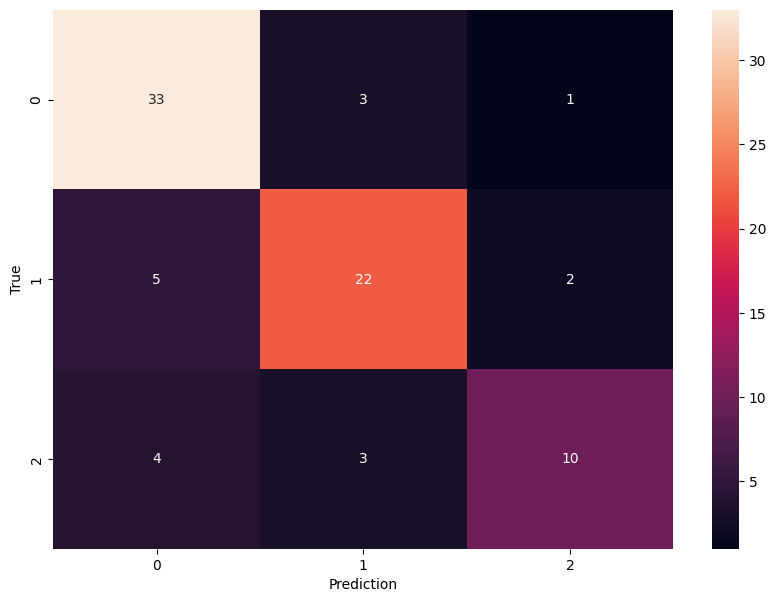

In [55]:
cm = confusion_matrix(y_actual,y_predictions)
plt.figure(figsize=(10,7))
sb.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()

In [58]:
print(classification_report(y_actual,y_predictions))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84        37
           1       0.79      0.76      0.77        29
           2       0.77      0.59      0.67        17

    accuracy                           0.78        83
   macro avg       0.78      0.75      0.76        83
weighted avg       0.78      0.78      0.78        83



### Plotting Model Performance

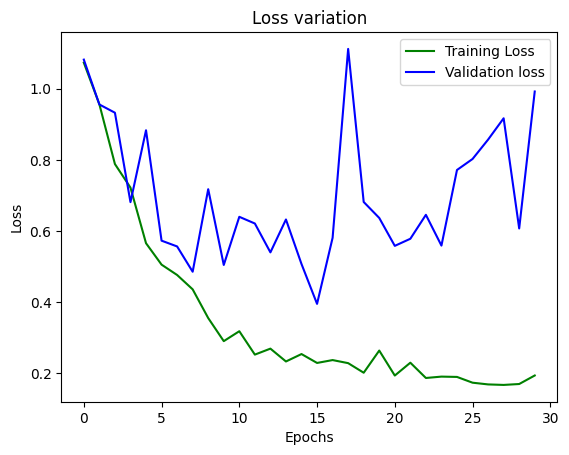

In [59]:
plt.plot(history.history['loss'],color='green',label='Training Loss')
plt.plot(history.history['val_loss'],color='blue',label='Validation loss')
plt.legend(loc='upper right')
plt.title('Loss variation')
plt.savefig('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

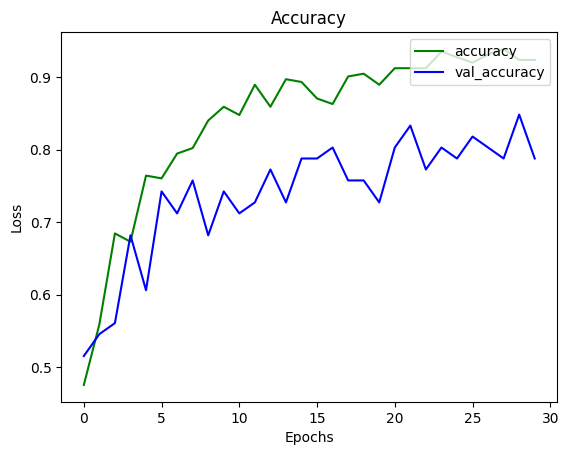

In [60]:
plt.plot(history.history['accuracy'], color = 'green', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy')
plt.legend(loc = 'upper right')
plt.show()

### Testing with random images

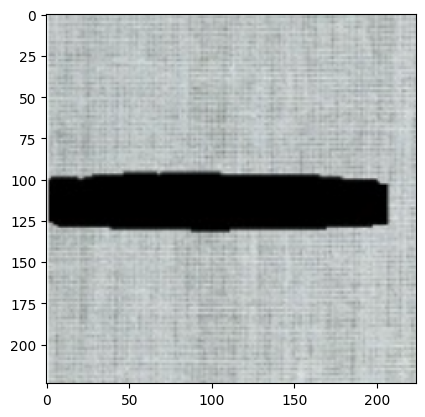

In [61]:
img_horizontal = cv2.imread('/content/Dataset/TestImages/test1.jpg')
resized_horizontal = tf.image.resize(img_horizontal,(224,224))
plt.imshow(resized_horizontal.numpy().astype(int))

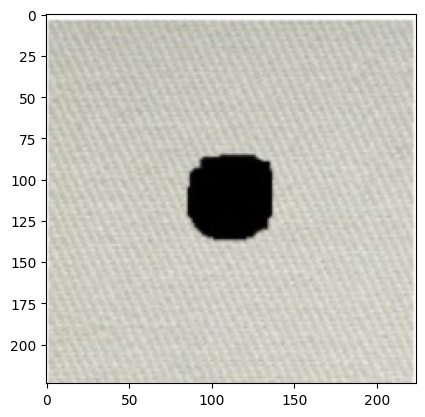

In [62]:
img_hole = cv2.imread('/content/Dataset/TestImages/test2.jpg')
resized_hole = tf.image.resize(img_hole,(224,224))
plt.imshow(resized_hole.numpy().astype(int))

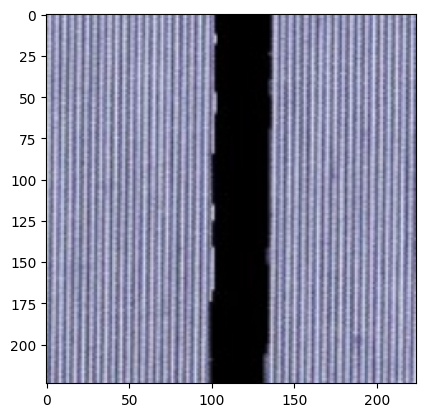

In [63]:
img_vertical = cv2.imread('/content/Dataset/TestImages/test3.jpg')
resized_vertical = tf.image.resize(img_vertical,(224,224))
plt.imshow(resized_vertical.numpy().astype(int))

In [64]:
resized_vertical = resized_vertical/255.0
resized_horizontal = resized_horizontal/255.0
resized_hole = resized_hole/255.0

In [65]:
input_vertical = tf.expand_dims(resized_vertical,axis=0)
input_horizontal = tf.expand_dims(resized_horizontal,axis=0)
input_hole = tf.expand_dims(resized_hole,axis=0)

In [66]:
prediction_1 = defect_classifier.predict(input_horizontal)
prediction_2 = defect_classifier.predict(input_hole)
prediction_3 = defect_classifier.predict(input_vertical)

predicted_class1 = np.argmax(prediction_1,axis=1).item()
predicted_class2 = np.argmax(prediction_2,axis=1).item()
predicted_class3 = np.argmax(prediction_3,axis=1).item()


1/1 [==============================] - 0s 27ms/step


In [67]:
predicted_label1 = defect_classes[predicted_class1]
predicted_label2 = defect_classes[predicted_class2]
predicted_label3 = defect_classes[predicted_class3]

print(f"Prediction of first image: {predicted_label1}")
print(f"Prediction of second image: {predicted_label2}")
print(f"Prediction of third image: {predicted_label3}")

Prediction of first image: Horizontal
Prediction of second image: Holes
Prediction of third image: Vertical


### Saving the model

In [68]:
model_folder = '/content/best_model'
os.makedirs(model_folder, exist_ok=True)
model_path = os.path.join(model_folder, 'classifier.model')
defect_classifier.save(model_path)
loaded_model = tf.keras.models.load_model(model_path)
prediction = loaded_model.predict(input_hole)
predicted_class = defect_classes[np.argmax(prediction,axis=1).item()]
print(f"Prediction of class: {predicted_class}")

1/1 [==============================] - 0s 120ms/step
Prediction of class: Holes


In [70]:
#Saving the model in file format
import pickle
filename = 'saved_model.sav'
pickle.dump(defect_classifier,open(filename,'wb'))
model = pickle.load(open('saved_model.sav','rb'))
prediction = model.predict(input_horizontal)
predicted_class = defect_classes[np.argmax(prediction,axis=1).item()]
print(f"Prediction of class: {predicted_class}")

1/1 [==============================] - 0s 88ms/step
Prediction of class: Horizontal
